In [420]:
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fao_ada.pre_processing.load import load_dataframe
from fao_ada.pre_processing.grouping import groupby_country_groups
from fao_ada.plotting import plot_stacked_bar_single_area_single_element, plot_world_map_slider, line_plot_single_element_single_area
%load_ext autoreload
%autoreload 2

country_groups = load_dataframe("data/country_groups.csv")
country_codes = load_dataframe("data/countries.csv")
population_df = load_dataframe("data_cleaned/population/Population_E_All_Data_(Normalized).csv")
  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dir_ = os.listdir("data_cleaned/")
files_ = [os.listdir("data_cleaned/" + val) for idx, val in enumerate(dir_)]

# How has the yield evolved across all elements for separate items?

How does the ratio emission / yield differ for items in different element groups and within a single group?


## Emissions agriculture soils
### Emissions Agriculture Cultivated Organic Soils
Loooking at emissions in CO2eq per land use for two types of land: croplands and grasslands.

In [573]:
emissions_agriculture_soils = load_dataframe("data_cleaned/emissions_agriculture/" + files_[0][4])

In [572]:
area = emissions_agriculture_soils[emissions_agriculture_soils.element == "Area"].drop(["areacode","itemcode","elementcode","unit"], axis = 1)
emissions = emissions_agriculture_soils[emissions_agriculture_soils.element == "Emissions (CO2eq) (Cultivation of organic soils)"]
soils_yield = area.merge(emissions, on = ["year","area","item"])
soils_yield["value"] = soils_yield.value_y/soils_yield.value_x
soils_yield = soils_yield[soils_yield.year <2019]
map_soils_yield = soils_yield.groupby(["area","year","areacode"]).agg({"value":"sum"}).reset_index()

In [431]:
plot_world_map_slider(map_soils_yield, "ratio","Ratio of Emissions in CO2 equivalent of Cultivation of Organic Soils, both Cropland and Grassland, and Area","Ratio")

We can see that there is data missing. Overall, the countries with the highest emission per area cultivated are in South America and Africa. The best ones seem to be Iceland and the Falkland Islands.

Let's take a look at these in 2017. We have to keep in mind that there is a lot of data missing, notable from Northern African countries, part of the Middle East and Mexico (plus in South America and Asia). Some of these countries possess a lot of agricultural soils! 

In [480]:
ratio_2017 = pd.DataFrame(soils_yield[soils_yield.year == 2017].sort_values("value").area.unique(),columns= ["Low to High 2017"]).reset_index()
ratio_1990 = pd.DataFrame(soils_yield[soils_yield.year == 1990].sort_values("value").area.unique(),columns= ["Low to High 1990"]).reset_index()
ratio_diff = ratio_1990.merge(ratio_2017, on = "index").drop("index",axis=1)
ratio_diff.head(5)

,Low to High 1990,Low to High 2017
0,Faroe Islands,Faroe Islands
1,Uruguay,Falkland Islands (Malvinas)
2,Chile,Chile
3,Iceland,Uruguay
4,Norway,Iceland


we can see that there are differences! Let's investigate which countries have a similar placing order.

In [483]:
ratio_diff[ratio_diff["Low to High 1990"] == ratio_diff["Low to High 2017"]].nunique()

Low to High 1990    11
Low to High 2017    11
dtype: int64

Only 11 countries have maintained their placement. But you can move up or down a bit without it mattering too much, we could investigate and see if there has been some major movements.

So now we have the full list, but this is only taking values in 2017 and from data available. Countries that have more developped, newer, and more larger scale, industrialized / automated agricultures tend to have lower emissions per area. However, we should remember that a paramount factor to emission per area is the type of crop being produced! Some crops require more area and tend to pollute more. This is true for both croplands and grasslands, althought the difference should be starker in croplands as for grasslands there is not much you cultivate.

Croplands are used to grow crops while grasslands are used to grow grasses / legumes, which in turn are used to feed livestock. However grasslands are *not* grazing lands.

Therefore we should focus our attention on emission per area for specific crops, and then analyze country-wise to see if there are differences.

In [434]:
plot_soils_yield = soils_yield.groupby(["year","elementcode","item","itemcode"]).agg({"value":"mean"}).reset_index()
plot_soils_yield["elementcode"]=0
plot_soils_yield["areacode"]=0

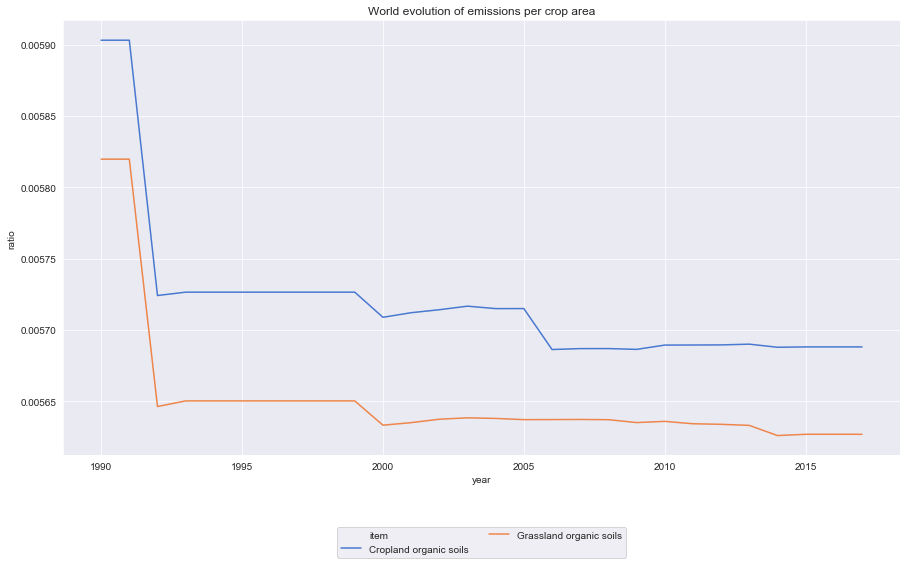

In [435]:
line_plot_single_element_single_area(plot_soils_yield, 0, 0, "World evolution of emissions per crop area","ratio")

The ratio does not seem to be going down by much over recent years. However, once again, we don't have a lot of data over the course of many years, and are missing information from important countries in this context.Both organic and cropland soils seem to be following the same trend.
There is a huge drop from 1991 to 1992. Let's look at the number of countries in both years.

In [488]:
soils_yield[soils_yield.year<1995].groupby(["year","item"]).agg({"area":"count"}).reset_index().drop_duplicates("year").drop("item",axis=1)

,year,area
0,1990,92
2,1991,92
4,1992,101
6,1993,103
8,1994,103


Indeed there is a big difference. Let's look at which countries were added.

In [437]:
set1991 = set(soils_yield[soils_yield.year==1991].area)
set1992 = set(soils_yield[soils_yield.year==1992].area)
set1992-set1991

{'Belarus',
 'Bosnia and Herzegovina',
 'Croatia',
 'Estonia',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Ukraine'}

The dip in 1991 is hard to explain. We could postulate that with the fall of the USSR in 1991, something happened with the way the data was handled. It would be unlikely that the ratio dip is actually caused by a decrease in emissions per agricultural soil cultivation use.

## Production crops
Looking at area harvested

In [441]:
production_crops = load_dataframe("data_cleaned/production/" + files_[5][0])
production_crops.head(1)

,areacode,area,itemcode,item,elementcode,element,year,unit,value
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,ha,0.0


In [442]:
qty_yield = production_crops[production_crops.element == "Area harvested"].groupby(["item"]).agg({"value":"mean"}).reset_index().sort_values("value", ascending = False)
print("{}\n \n{}".format(qty_yield.iloc[0], qty_yield.iloc[-1]))

item     Cotton lint
value    2.80565e+06
Name: 43, dtype: object
 
item     Jojoba seed
value        351.722
Name: 71, dtype: object


We can see that the yield of quantity produced divided by area harvested is very different for different items. 

#### Taking a look at which items have the most quantity produced.

In [518]:
production_crops.element.unique()

array(['Area harvested', 'Yield', 'Production'], dtype=object)

In [555]:
top_area = list(production_crops[production_crops.element == "Area harvested"].groupby(["item"]).agg({"value":"mean"}).sort_values("value", ascending = False).reset_index()[:5].item)
top_prod = list(production_crops[production_crops.element == "Production"].groupby(["item"]).agg({"value":"mean"}).sort_values("value", ascending = False).reset_index()[:5].item)
selected_crops = production_crops[ (production_crops.item.isin(top_area)) | (production_crops.item.isin(top_prod)) ]
selected_crops.item.unique()

array(['Cotton lint', 'Maize', 'Rice, paddy', 'Sugar beet', 'Sugar cane',
       'Wheat', 'Soybeans'], dtype=object)

In [556]:
plot_selected_crops = selected_crops.groupby(["itemcode","item","elementcode","element","year"]).agg({"value":"sum"}).reset_index()
plot_selected_crops["areacode"] = 0

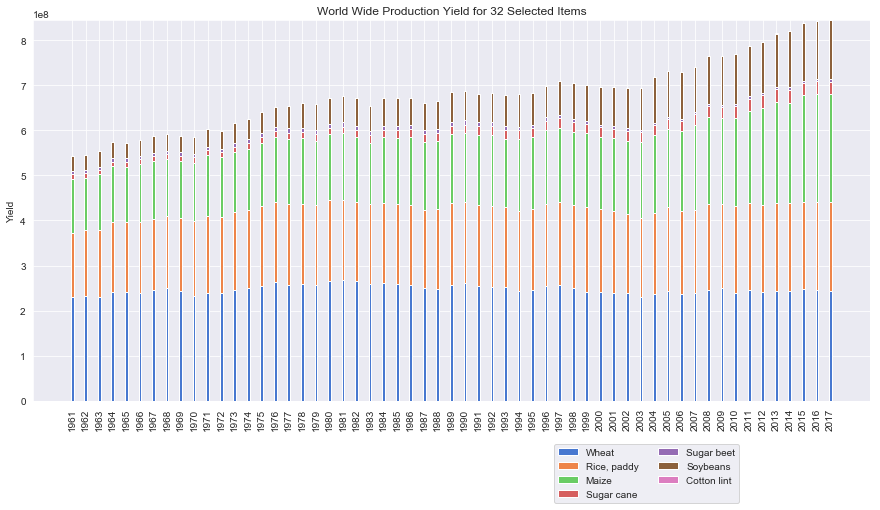

In [557]:
plot_stacked_bar_single_area_single_element(plot_selected_crops, 5312, 0, "World Wide Production Yield for 32 Selected Items","Yield")

We can see that the yield looks stable for the selected categories. However, two categories have shown a great increase for Maize and Soybeans.

#### Anomalies

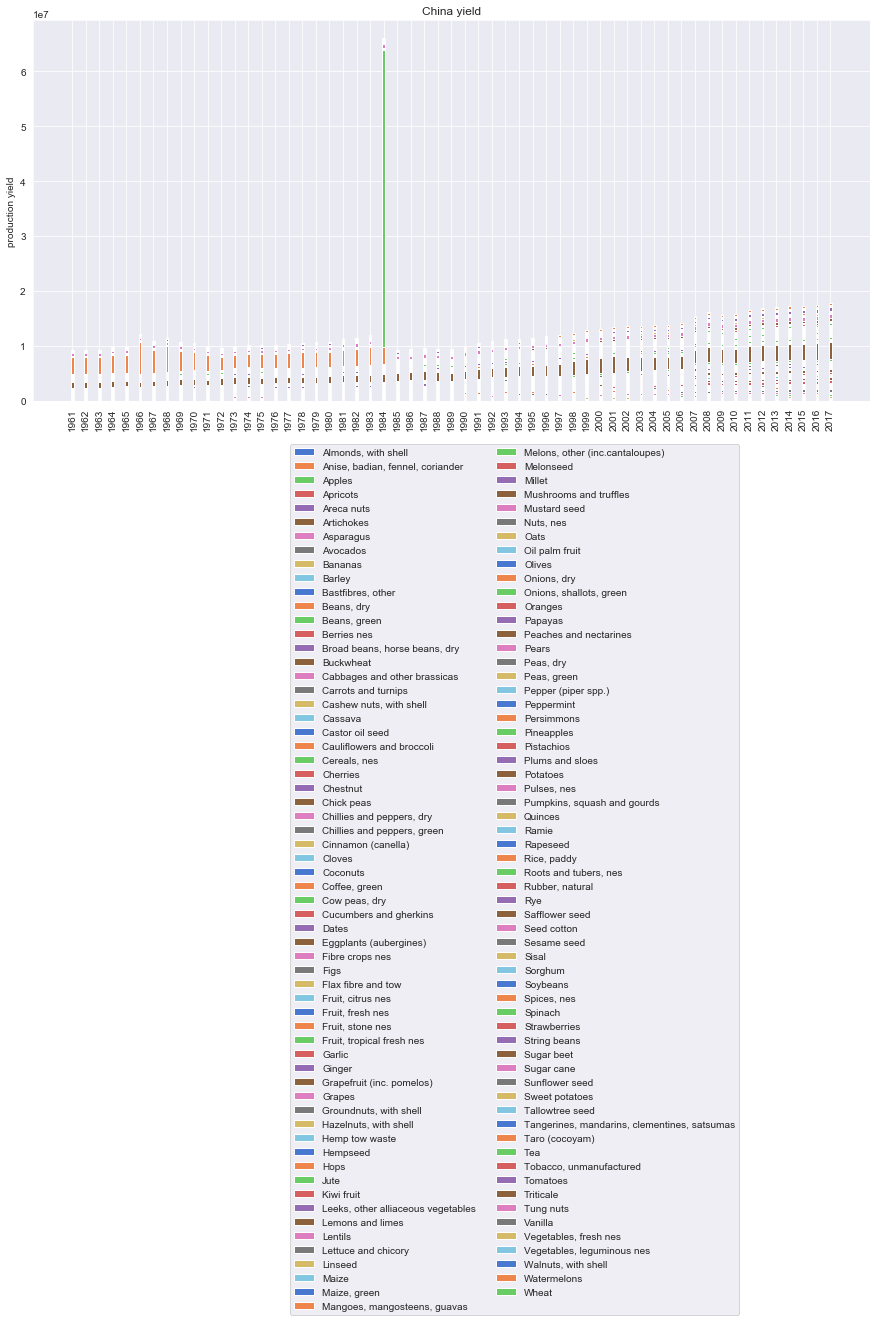

In [446]:
plot_stacked_bar_single_area_single_element(production_crops, 5419, 351, "China yield", "production yield")

In [502]:
production_crops[(production_crops.year == 1984) & (production_crops.element == "Yield")].value.sort_values(ascending = False).head(1)

256174    54157895.0
Name: value, dtype: float64

In [448]:
production_crops.iloc[256174]

areacode               351
area                 China
itemcode               373
item               Spinach
elementcode           5419
element              Yield
year                  1984
unit                 hg/ha
value          5.41579e+07
Name: 256174, dtype: object

We can see that there are anomalies with the dataset, with the yield of spinach in China in 1984 skyrocketing, for a single year. We have checked online sources for a special event at this time and lcoation that could justify this peak and have found none. The peak means that the production quantity has increased (a lot) when compared to the area harvested. This could be explained by imports that were not well accounted for in the database, but overall should be considered as a faulty data point. 

## Production livestock primary

In [584]:
production_livestock_primary = load_dataframe("data_cleaned/production/" + files_[5][1])

two different element codes... because different units. 

In [607]:
meat = production_livestock_primary[(production_livestock_primary.item.str.contains('Meat')) & ~(production_livestock_primary.item.str.contains('indigenous'))]
bar_meat = meat.groupby(["itemcode","item","elementcode","element","year"]).agg({"value":"sum"}).reset_index()
bar_meat["areacode"]=0

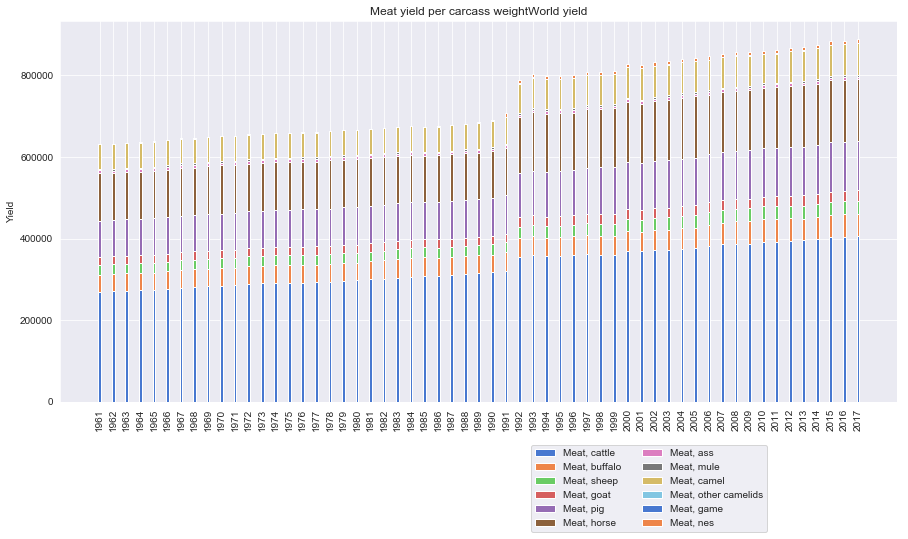

In [614]:
plot_stacked_bar_single_area_single_element(bar_meat, 5417, 0, "Meat yield per carcass weight", "Yield")

In [471]:
bar_livestock = livestock_yield.groupby(["itemcode","item","elementcode","element","year"]).agg({"value":"sum"}).reset_index()
bar_livestock["areacode"]=0

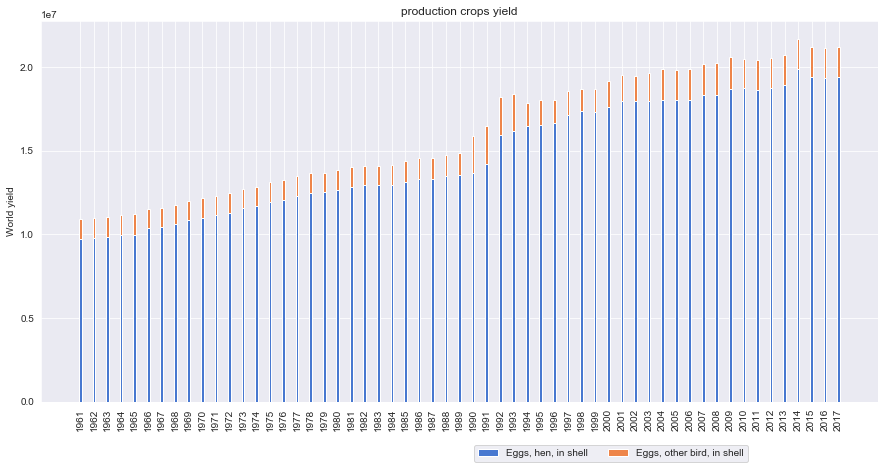

In [615]:
plot_stacked_bar_single_area_single_element(bar_livestock, 5410, 0, "production crops yield", "World yield")

As we can see the yield is increasing reliably over the years, both for eggs from hens and other birds. The yield is much higher in hens, as expected by the industrialization and mass-production techniques used specifically for hens. Hens are cheaper to use and breed than other birds and lay numerous amounts of eggs compared to other species. 


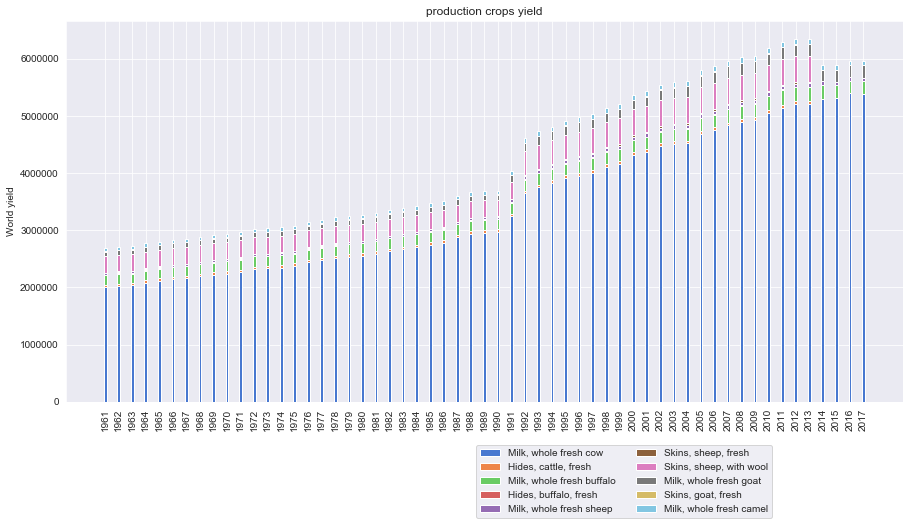

In [616]:
plot_stacked_bar_single_area_single_element(bar_livestock, 5420, 0, "production crops yield", "World yield")

As we can see, the highest yield comes from fresh cow milk. There is a strong increase as well. It seems that there is missing data starting in 2013.

In [561]:
set(livestock_yield[livestock_yield.year == 2013].area.unique()) - set(livestock_yield[livestock_yield.year == 2014].area.unique())

{'British Virgin Islands', 'Faroe Islands'}

Not because of changing countries. So maybe the Data is not being collected anymore.

In [571]:
bar_livestock[bar_livestock.item == "Milk, whole fresh cow"].year.count() - bar_livestock[bar_livestock.item == "Skins, sheep, with wool"].year.count()

4

So the data is just not there anymore for this category, starting in 2014.

## Environment and pesticides, FERTILIZERS

 Pesticides
 
 fertilizers

In [574]:
files_

[['Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).csv',
  'Emissions_Agriculture_Burning_crop_residues_E_All_Data_(Normalized).csv',
  'Emissions_Agriculture_Burning_Savanna_E_All_Data_(Normalized).csv',
  'Emissions_Agriculture_Crop_Residues_E_All_Data_(Normalized).csv',
  'Emissions_Agriculture_Cultivated_Organic_Soils_E_All_Data_(Normalized).csv',
  'Emissions_Agriculture_Energy_E_All_Data_(Norm).csv',
  'Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Normalized).csv',
  'Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Normalized).csv',
  'Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Normalized).csv',
  'Emissions_Agriculture_Manure_Management_E_All_Data_(Normalized).csv',
  'Emissions_Agriculture_Synthetic_Fertilizers_E_All_Data_(Normalized).csv'],
 ['Emissions_Land_Use_Land_Use_Total_E_All_Data_(Normalized).csv'],
 ['Environment_AirClimateChange_E_All_Data.csv',
  'Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv',
  'Envir

In [586]:
production_livestock= load_dataframe("data_cleaned/production/" + files_[5][2])

In [587]:
production_livestock.item.unique()

array(['Asses', 'Camels', 'Cattle', 'Chickens', 'Goats', 'Horses',
       'Mules', 'Sheep', 'Beehives', 'Buffaloes', 'Ducks',
       'Geese and guinea fowls', 'Pigs', 'Turkeys', 'Rabbits and hares',
       'Camelids, other', 'Rodents, other', 'Animals live nes',
       'Pigeons, other birds'], dtype=object)

## Population

Now we will normalize results by capita to get a more fair global ranking of countries.


In [440]:
population = load_dataframe("data_cleaned/population/"  + files_[4][0])
population.head(1)

,areacode,area,itemcode,item,elementcode,element,year,unit,value,note
0,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1950,1000 persons,7752.118,NaN


With all this information, we want to build a stronger indicator of country emission that we can than normalize by capita. 
We want to take into account:
- overall emissions that are agriculture based. We have computed a yield of emissions per production soil, for both croplands and grasslands (the latter being used for livestock grazing?).
- overall yield of crop and livestock per area harvested.
- we want to compute a quantity per land per emission?

- Now we can take a look at which type of polluant is used with respect to agriculture for each country to try to explain differences in emissions for countries with similar crop plantation